<h2> Automatic filtering </h2> 

In [1]:
# import packages
import csv
import pandas as pd
import re
from bs4 import BeautifulSoup
import requests
import os
import numpy as np
import string
import math
from nltk import ngrams
import PyPDF2
import json
import time
import seaborn as sns
from matplotlib import pyplot as plt
import shutil
from nltk import tokenize

In [2]:
# import internal modules
import file_path_management as fpath
import public_library as plib
import extract_info
import parameters as params
import download_and_process_pdf as dpp

2023-10-05 14:37:44 GM01X680 metapub.config[23592] WARNING NCBI_API_KEY was not set.


<h3> Predefined fucntions: </h3> 

In [3]:
def count_keyword(text, keyword):
    # remove non-alphabetic characters but keep spaces and "-"
    text = text.lower()
    text = re.sub(r'[^a-z\s\-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # print(text)
    
    # words = []
    # n = keyword_length
    # n_grams = ngrams(text.split(), n)
    # for gram in n_grams:
    #     word = gram[0]
    #     if n > 0:
    #         for i in range(1, n):
    #             word = word + " " + gram[i]
    #     words.append(word)
    # # print(words)
    
    # word_count = 0
    # for word in words:
    #     # print(word)
    #     if word == keyword:
    #         word_count += 1
    word_count = text.count(keyword)
    # print(word_count)
    return word_count
# --------------------start of test code--------------------
# text = 'This apple 6i7s very_tasty？、  2but th&e banana this is not delicious at Is all.6'
# # text = "Distribution of the dopamine innervation in the macaque and human thalamus Miguel Ángel García-Cabezas,aBeatriz Rico,a,b Miguel Ángel Sánchez-González,aand Carmen Cavadaa,⁎ aDepartamento de Anatomía, Histología y Neurociencia, Facultad de Medicina, Universidad Autónoma de Madrid, C/Arzobispo Morcillo s/n, 28029 Madrid, Spain bInstituto de Neurociencias de Alicante, Universidad Miguel Hernández-CSIC, 03550 Sant Joan d ’Alacant, Spain Received 19 April 2006; revised 8 June 2006; accepted 11 July 2006 Available online 30 November 2006 We recently defined the thalamic dopaminergic system in primates; it arises from numerous dopaminergic cell groups and selectively targetsnumerous thalamic nuclei. Given the central position of the thalamus in subcortical and cortical interplay, and the functional relevance of dopamine neuromodulation in the brain, detailing dopamine dis-tribution in the thalamus should supply important information. Tothis end we performed immunohistochemistry for dopamine and the dopamine transporter in the thalamus of macaque monkeys and humans to generate maps, in the stereotaxic coronal plane, of thedistribution of dopaminergic axons. The dopamine innervation of the thalamus follows the same pattern in both species and is most dense in midline limbic nuclei, the mediodorsal and lateral posteriorassociation nuclei, and in the ventral lateral and ventral anteriormotor nuclei. This distribution suggests that thalamic dopamine has a prominent role in emotion, attention, cognition and complex somatosensory and visual processing, as well as in motor control.Most thalamic dopaminergic axons are thin and varicose and targetboth the neuropil and small blood vessels, suggesting that, besides neuronal modulation, thalamic dopamine may have a direct influence on microcirculation. The maps provided here should be a usefulreference in future experimental and neuroimaging studies aiming atclarifying the role of the thalamic dopaminergic system in health and in conditions involving brain dopamine, including Parkinson ’s disease, drug addiction and schizophrenia.© 2006 Elsevier Inc. All rights reserved. Keywords: Dopamine; Thalamus; Monkey; Human; Primate; Dopamine transporter; Parkinson; Schizophrenia; AddictionIntroduction The thalamus is made up of multiple nuclei relaying information from subcortical centers or from other cortices to the cerebral cortex (Sherman and Guillery, 2005 ), as well as the striatum, the nucleus accumbens and the amygdala ( Steriade et al., 1997 ). In addition to specific subcortical and cortical afferents, the primate thalamus receives axons containing the neuromodulators acetylcholine (Heckers et al., 1992 ), histamine ( Manning et al., 1996 ), serotonin (Morrison and Foote, 1986; Lavoie and Parent, 1991 ), and the catecholamines adrenaline ( Rico and Cavada, 1998a ), noradrenaline (Morrison and Foote, 1986; Ginsberg et al., 1993 ) and dopamine (Sánchez-González et al., 2005 ). Until recently, the existence of significant dopamine innervation in the primate thalamus has been largely ignored, probably becausedopamine innervation of the rodent thalamus is very scant(Groenewegen, 1988; Papadopoulos and Parnavelas, 1990 ). However, fragmentary data scattered through the literature endorse the presence of dopamine innervation in the primate thalamus.Postmortem biochemical studies showed the presence of dopamine in the thalamus of macaques ( Brown et al., 1979; Goldman-Rakic and Brown, 1981; Pifl et al., 1990, 1991 ) and human subjects ( Oke and Adams, 1987 ). Later, receptor binding and in situ hybridization analyses detected the presence of dopamine D2-like ( Joyce et al., 1991; Kessler et al., 1993; Hall et al., 1996; Langer et al., 1999;Rieck et al., 2004 ) and D3-like receptors ( Gurevich and Joyce, 1999 ) in several human thalamic nuclei. Positron emission tomography (PET) radioligand studies have also demonstratedthe presence of the dopamine transporter (DAT) ( Wang et al., 1995; Halldin et al., 1996; Helfenbein et al., 1999; Brownell et al., 2003 ) and of D2-like receptors ( Farde et al., 1997; Langer et al., 1999; Okubo et al., 1999; Brownell et al., 2003; Rieck et al., 2004 ) in the human and macaque thalamus. In the course of PET studies focusing on schizophrenia, D2- and D3-like radioligand binding was also found in the thalamus of control subjects ( Talvik et al., 2003; Yasuno et al., 2004 ). Finally, an immunohistochemical study using anti-DAT antibodies detected the presence of dopaminergic www.elsevier.com/locate/ynimg NeuroImage 34 (2007) 965 –984 ⁎Corresponding author. Fax: +34 91 497 53 15. E-mail address: carmen.cavada@uam.es (C. Cavada). Available online on ScienceDirect (www.sciencedirect.com). 1053-8119/$ - see front matter © 2006 Elsevier Inc. All rights reserved. doi:10.1016/j.neuroimage.2006.07.032"
# keyword = 'but the'
# count = count_keyword(text, keyword)
# print(count)
# ---------------------end of test code---------------------

In [4]:
def count_on_topic_kws_from_liter(text_tak, text_txt, on_topic_kws, type):
    # text_tak = ''.join(e for e in text_tak if (e.isalpha() or e == " " or e == "-"))
    # text_tak = text_tak.strip().lower()
    # text_tak = ' '.join(text_tak.split())
    if text_txt == text_txt and text_txt != "":
        text = text_txt
    else:
        text = text_tak

    text = text.lower()
    text = re.sub(r'[^a-z\s\-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # print(text_tak)

    # text_txt = ''.join(e for e in text_txt if (e.isalpha() or e == " " or e == "-"))
    # text_txt = text_txt.strip().lower()
    # text_txt = ' '.join(text_txt.split())
    # # print(text_txt)

    # text_text = text_tak + " " + text_txt

    # length_tak = len(text_tak.split())
    # length_txt = len(text_txt.split())
    # length_text = length_tak + length_txt
    length_text = len(text.split())

    # keywords_count = dict()
    # keywords_freq = dict()

    word_count = 0
    # count the on-topic keywords
    for word in on_topic_kws:
        # print(on_topic_kws[i])
        word_count = word_count + count_keyword(text, word)
        # print(word_count)
        # if type == "freq":
        #     # keywords_freq[on_topic_kws[i]] = round(word_count * 10 / length_text, 2)
        #     fre = round(word_count * 10 / length_text, 2)
        # elif type == "count":
        #     count = word_count
        # else:
        #     print("Error! Wrong type!")
    
    # if text_tak == text_tak:
    #     word_count = round(word_count / 2) 
    # fre = round(word_count * 10 / length_text, 2)
    # print(keywords_count)
    return word_count
# --------------------start of test code--------------------
# text_tak = 'Vision for action: thalamic and cortical inputs to the macaque superior tract neural tracing, parietal lobule The dorsal visual stream, the cortical circuit that in the primate brain is mainly dedicated to the visual control of actions, is split into two routes, a lateral and a medial one, both involved in coding different aspects of sensorimotor control of actions. The lateral route, named "lateral grasping network", is mainly involved in the control of the distal part of prehension, namely grasping and manipulation. The medial route, named "reach-to-grasp network", is involved in the control of the full deployment of prehension act, from the direction of arm movement to the shaping of the hand according to the object to be grasped. In macaque monkeys, the reach-to-grasp network (the target of this review) includes areas of the superior parietal lobule (SPL) that hosts visual and somatosensory neurons well suited to control goal-directed limb movements toward stationary as well as moving objects. After a brief summary of the neuronal functional properties of these areas, we will analyze their cortical and thalamic inputs thanks to retrograde neuronal tracers separately injected into the SPL areas V6, V6A, PEc, and PE. These areas receive visual and somatosensory information distributed in a caudorostral, visuosomatic trend, and some of them are directly connected with the dorsal premotor cortex. This review is particularly focused on the origin and type of visual information reaching the SPL, and on the functional role this information can play in guiding limb interaction with objects in structured and dynamic environments. Area PEc; Area V6; Area V6A; Dorsal visual stream; Goal-directed arm movement; Sensorimotor integration.'
# text_txt = "Distribution of the dopamine innervation in the macaque and human thalamus Miguel Ángel García-Cabezas,aBeatriz Rico,a,b Miguel Ángel Sánchez-González,aand Carmen Cavadaa,⁎ aDepartamento de Anatomía, Histología y Neurociencia, Facultad de Medicina, Universidad Autónoma de Madrid, C/Arzobispo Morcillo s/n, 28029 Madrid, Spain bInstituto de Neurociencias de Alicante, Universidad Miguel Hernández-CSIC, 03550 Sant Joan d ’Alacant, Spain Received 19 April 2006; revised 8 June 2006; accepted 11 July 2006 Available online 30 November 2006 We recently defined the thalamic dopaminergic system in primates; it arises from numerous dopaminergic cell groups and selectively targetsnumerous thalamic nuclei. Given the central position of the thalamus in subcortical and cortical interplay, and the functional relevance of dopamine neuromodulation in the brain, detailing dopamine dis-tribution in the thalamus should supply important information. Tothis end we performed immunohistochemistry for dopamine and the dopamine transporter in the thalamus of macaque monkeys and humans to generate maps, in the stereotaxic coronal plane, of thedistribution of dopaminergic axons. The dopamine innervation of the thalamus follows the same pattern in both species and is most dense in midline limbic nuclei, the mediodorsal and lateral posteriorassociation nuclei, and in the ventral lateral and ventral anteriormotor nuclei. This distribution suggests that thalamic dopamine has a prominent role in emotion, attention, cognition and complex somatosensory and visual processing, as well as in motor control.Most thalamic dopaminergic axons are thin and varicose and targetboth the neuropil and small blood vessels, suggesting that, besides neuronal modulation, thalamic dopamine may have a direct influence on microcirculation. The maps provided here should be a usefulreference in future experimental and neuroimaging studies aiming atclarifying the role of the thalamic dopaminergic system in health and in conditions involving brain dopamine, including Parkinson ’s disease, drug addiction and schizophrenia.© 2006 Elsevier Inc. All rights reserved. Keywords: Dopamine; Thalamus; Monkey; Human; Primate; Dopamine transporter; Parkinson; Schizophrenia; AddictionIntroduction The thalamus is made up of multiple nuclei relaying information from subcortical centers or from other cortices to the cerebral cortex (Sherman and Guillery, 2005 ), as well as the striatum, the nucleus accumbens and the amygdala ( Steriade et al., 1997 ). In addition to specific subcortical and cortical afferents, the primate thalamus receives axons containing the neuromodulators acetylcholine (Heckers et al., 1992 ), histamine ( Manning et al., 1996 ), serotonin (Morrison and Foote, 1986; Lavoie and Parent, 1991 ), and the catecholamines adrenaline ( Rico and Cavada, 1998a ), noradrenaline (Morrison and Foote, 1986; Ginsberg et al., 1993 ) and dopamine (Sánchez-González et al., 2005 ). Until recently, the existence of significant dopamine innervation in the primate thalamus has been largely ignored, probably becausedopamine innervation of the rodent thalamus is very scant(Groenewegen, 1988; Papadopoulos and Parnavelas, 1990 ). However, fragmentary data scattered through the literature endorse the presence of dopamine innervation in the primate thalamus.Postmortem biochemical studies showed the presence of dopamine in the thalamus of macaques ( Brown et al., 1979; Goldman-Rakic and Brown, 1981; Pifl et al., 1990, 1991 ) and human subjects ( Oke and Adams, 1987 ). Later, receptor binding and in situ hybridization analyses detected the presence of dopamine D2-like ( Joyce et al., 1991; Kessler et al., 1993; Hall et al., 1996; Langer et al., 1999;Rieck et al., 2004 ) and D3-like receptors ( Gurevich and Joyce, 1999 ) in several human thalamic nuclei. Positron emission tomography (PET) radioligand studies have also demonstratedthe presence of the dopamine transporter (DAT) ( Wang et al., 1995; Halldin et al., 1996; Helfenbein et al., 1999; Brownell et al., 2003 ) and of D2-like receptors ( Farde et al., 1997; Langer et al., 1999; Okubo et al., 1999; Brownell et al., 2003; Rieck et al., 2004 ) in the human and macaque thalamus. In the course of PET studies focusing on schizophrenia, D2- and D3-like radioligand binding was also found in the thalamus of control subjects ( Talvik et al., 2003; Yasuno et al., 2004 ). Finally, an immunohistochemical study using anti-DAT antibodies detected the presence of dopaminergic www.elsevier.com/locate/ynimg NeuroImage 34 (2007) 965 –984 ⁎Corresponding author. Fax: +34 91 497 53 15. E-mail address: carmen.cavada@uam.es (C. Cavada). Available online on ScienceDirect (www.sciencedirect.com). 1053-8119/$ - see front matter © 2006 Elsevier Inc. All rights reserved. doi:10.1016/j.neuroimage.2006.07.032"
# on_topic_kws = params.ranking_params
# keywords_count = count_on_topic_kws_from_liter(text_tak, text_txt, on_topic_kws, 'count')
# print(keywords_count)
# ---------------------end of test code---------------------

In [5]:
def calcul_index(group, ranking_params_weights):
    for key in group.keys():
        map = math.log(1 + group[key])
        index += map * (ranking_params_weights[key])
    return index
# --------------------start of test code--------------------
# keywords_count_or_fre = {}
# index = calcul_related(keywords_count_or_fre, params.on_topic_kws_weights)
# print(index)
# ---------------------end of test code---------------------

In [6]:
def weight_and_count(input_path, output_path, ranking_params, ranking_params_weights):
    df = pd.read_csv(input_path, header=None, sep=",")
    df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

    for ind in df.index:
        index = str(int(df.at[ind, "INDEX"]))
        txt_file_name = str(index) + ".txt"
        txt_path = os.path.join(fpath.text_folder, txt_file_name)

        text_tak = ""
        text_txt = ""

        if df.at[ind, "TITLE"] == df.at[ind, "TITLE"]:
            text_tak = text_tak + " " + df.at[ind, "TITLE"]
        else:
            pass  
        if df.at[ind, "ABSTRACT"] == df.at[ind, "ABSTRACT"]:
            text_tak = text_tak + " " + df.at[ind, "ABSTRACT"]
        else:
            pass
        if df.at[ind, "KEYWORDS"] == df.at[ind, "KEYWORDS"]:
            text_tak = text_tak + " " + df.at[ind, "KEYWORDS"]
        else:
            pass
        # print(text_tak)

        if os.path.exists(txt_path):
            with open(txt_path, "r") as f:
                text_txt = f.read()
                # extract first 500 words from text_txt
                text_txt = ' '.join(text_txt.split()[:500])
            f.close()
        else:
            pass
            # print(".txt file not found:", ind, index, df.at[ind, "PDF_URL"])
        
        # on_topic_kws = [key for key in on_topic_kws_weights.keys()]
        # # length_tak, length_txt, length_text, keywords_count = count_on_topic_kws_from_liter(text_tak, text_txt, on_topic_kws, "count")
        # length_tak, length_txt, length_text, keywords_freq = count_on_topic_kws_from_liter(text_tak, text_txt, on_topic_kws, "freq")
        for param in ranking_params:
            if param == 'species':
                species = count_on_topic_kws_from_liter(text_tak, text_txt, params.species_related, 'count')
            elif param == 'tc_ct':
                tc_ct = count_on_topic_kws_from_liter(text_tak, text_txt, params.tc_ct_related, 'count')
            elif param == 'thalam':
                thalam = count_on_topic_kws_from_liter(text_tak, text_txt, params.thalam_related, 'count')
            elif param == 'cortex':
                cortex = count_on_topic_kws_from_liter(text_tak, text_txt, params.cortex_related, 'count')
            elif param == 'method':
                method = count_on_topic_kws_from_liter(text_tak, text_txt, params.method_related, 'count')
            elif param == 'connectivity':
                connectivity = count_on_topic_kws_from_liter(text_tak, text_txt, params.connectivity_related, 'count')
            else:
                print("Error! Wrong param!")


        columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
                   "TITLE", "ABSTRACT", "KEYWORDS", 
                   "SPECIES_RELATED", "TC_CT_RELATED", "THALAM_RELATED", "CORTEX_RELATED", "METHOD_RELATED", "CONNECTIVITY_RELATED"]
        
        # columns = columns + [key for key in keywords_count.keys()]

        row = {
            "INDEX": [df.at[ind, "INDEX"]],
            "DOI": [df.at[ind, "DOI"]],
            "PMID": [df.at[ind, "PMID"]],
            "PMCID": [df.at[ind, "PMCID"]],
            "FULL_TEXT_URL": [df.at[ind, "FULL_TEXT_URL"]],
            "FULL_TEXT_SOURCE": [df.at[ind, "FULL_TEXT_SOURCE"]],
            "PDF_URL": [df.at[ind, "PDF_URL"]],
            "PDF_SOURCE": [df.at[ind, "PDF_SOURCE"]],
            "TITLE": [df.at[ind, "TITLE"]],
            "ABSTRACT": [df.at[ind, "ABSTRACT"]],
            "KEYWORDS": [df.at[ind, "KEYWORDS"]],
            "SPECIES_RELATED": [species],
            "TC_CT_RELATED": [tc_ct],
            "THALAM_RELATED": [thalam],
            "CORTEX_RELATED": [cortex],
            "METHOD_RELATED": [method],
            "CONNECTIVITY_RELATED": [connectivity]
        }
        
        # for key in on_topic_kws:
        #     row[key] = [keywords_count[key]]
        # print(row)

        if not plib.add_row_to_csv(output_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        line_number_in_csv = ind + 1
        print("Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_litera_db
# output_path = fpath.poten_litera_litera_db_ranked
# weight_and_rank(input_path, output_path)
# ---------------------end of test code---------------------

In [7]:
def rank(input_path, output_path, ranking_params_weights):
    df = pd.read_csv(input_path, header=None, sep=",")
    df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
                   "TITLE", "ABSTRACT", "KEYWORDS", 
                   "SPECIES_RELATED", "TC_CT_RELATED", "THALAM_RELATED", "CORTEX_RELATED", "METHOD_RELATED", "CONNECTIVITY_RELATED"]
    
    for ind in df.index:
        group = {
            'species': df.at[ind, 'SPECIES_RELATED'], 
            'tc_ct': df.at[ind, 'TC_CT_RELATED'], 
            'thalam': df.at[ind, 'THALAM_RELATED'], 
            'cortex': df.at[ind, 'CORTEX_RELATED'], 
            'method': df.at[ind, 'METHOD_RELATED'], 
            'connectivity': df.at[ind, 'CONNECTIVITY_RELATED']}

        # relev_index = calcul_index(keywords_count, on_topic_kws_weights)
        relev_index = calcul_index(group, ranking_params_weights)
        # print(index)

    #     columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
    #                "TITLE", "ABSTRACT", "KEYWORDS", 
    #                "SPECIES_RELATED", "TC_CT_RELATED", "THALAM_RELATED", "CORTEX_RELATED", "METHOD_RELATED", "CONNECTIVITY_RELATED",
    #                "RELEVANCE_INDEX"]
            
    #     # columns = columns + [key for key in keywords_count.keys()]

    # row = {
    #     "INDEX": [df.at[ind, "INDEX"]],
    #     "DOI": [df.at[ind, "DOI"]],
    #     "PMID": [df.at[ind, "PMID"]],
    #     "PMCID": [df.at[ind, "PMCID"]],
    #     "FULL_TEXT_URL": [df.at[ind, "FULL_TEXT_URL"]],
    #     "FULL_TEXT_SOURCE": [df.at[ind, "FULL_TEXT_SOURCE"]],
    #     "PDF_URL": [df.at[ind, "PDF_URL"]],
    #     "PDF_SOURCE": [df.at[ind, "PDF_SOURCE"]],
    #     "TITLE": [df.at[ind, "TITLE"]],
    #     "ABSTRACT": [df.at[ind, "ABSTRACT"]],
    #     "KEYWORDS": [df.at[ind, "KEYWORDS"]],
    #     "SPECIES_RELATED": [df.at[ind, "SPECIES_RELATED"]],
    #     "TC_CT_RELATED": [df.at[ind, "TC_CT_RELATED"]],
    #     "THALAM_RELATED": [df.at[ind, "THALAM_RELATED"]],
    #     "CORTEX_RELATED": [df.at[ind, "CORTEX_RELATED"]],
    #     "METHOD_RELATED": [df.at[ind, "METHOD_RELATED"]],
    #     "CONNECTIVITY_RELATED": [df.at[ind, "CONNECTIVITY_RELATED"]],
    #     "RELEVANCE_INDEX": [relev_index]
    # }

        df.at[ind, 'RELEVANCE_INDEX'] = relev_index

    # rank
    # df_ranked = pd.read_csv(output_path, header=0, sep=",")
    # df_ranked.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
    #                "TITLE", "ABSTRACT", "KEYWORDS", 
    #                "LENGTH_TAK", "LENGTH_TXT", "LENGTH_TEXT","RELEVANCE_INDEX"]
    df_ranked = df.sort_values(by="RELEVANCE_INDEX", ascending=False)
    df_ranked.reset_index(drop=True, inplace=True)
    df_ranked.to_csv(output_path, header=True, index=False)
    print("Weighting and ranking the potentially related literature succeded!")
    print("Enjoy reading!")

<h3> Main program: </h3> 

count: 9892
max: 1307
average: 235.22169429842296
median: 231.0
std: 79.78628247923577


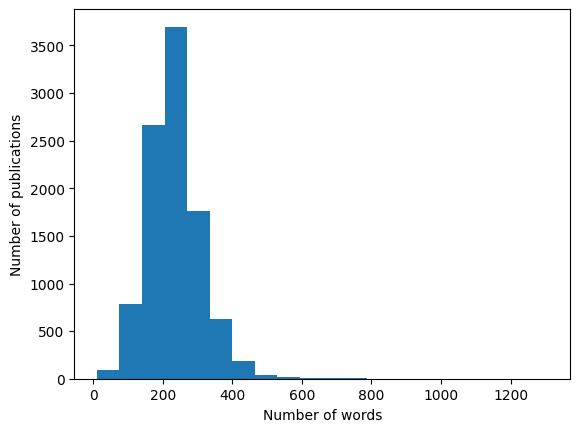

In [8]:
# the distribution of text length in the title + keywords + abstract
input_path = fpath.poten_litera_db
df = pd.read_csv(input_path, header=None, sep=',')
df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

len_list = []

for ind in df.index:
    if df.at[ind, "ABSTRACT"] == df.at[ind, "ABSTRACT"]:
        abstract = df.at[ind, "ABSTRACT"].strip()
    else:
        continue
    if df.at[ind, "TITLE"] == df.at[ind, "TITLE"]:
        title = df.at[ind, "TITLE"].strip()
    else:
        title = ""
    if df.at[ind, "KEYWORDS"] == df.at[ind, "KEYWORDS"]:
        keywords = df.at[ind, "KEYWORDS"].strip()
    else:
        keywords = ""

    text = title + " " + abstract + " " + keywords
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    num_words = len(text.split())

    len_list.append(num_words)

# calculate the average and maximum number of words in the text
print("count:", len(len_list))
print("max:", max(len_list))
print("average:", np.mean(len_list))
print("median:", np.median(len_list))
print("std:", np.std(len_list))

# sort the len_list and draw a histogram
len_list.sort()
plt.hist(len_list, bins=20)
plt.xlabel("Number of words")
plt.ylabel("Number of publications")
plt.show()

# count: 9892
# max: 1307
# average: 238.4487464617873
# median: 233.0
# std: 81.67288207132555

In [9]:
# # scan the text in the database, and extract all sentences that contains certain keyowrds and save them into the database
# input_path = fpath.poten_litera_db
# output_path = fpath.poten_litera_db_text_extract
# plib.clear_file(output_path)

# keywords_group = [
#     ['rhesus', 'macaque', 'macaca'],
#     ['thalam'],
#     ['inject']
# ]

# df = pd.read_csv(input_path, header=None, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS"]

# for ind in df.index:
#     text_group = ['', '', '']

#     index = str(int(df.at[ind, "INDEX"]))
    
#     txt_file_name = str(index) + ".txt"
#     txt_path = os.path.join(fpath.text_folder, txt_file_name)

#     text = ''

#     # extract text
#     if os.path.exists(txt_path):
#         # open the txt file and read all text
#         with open(txt_path, 'r') as f:
#             text = f.read()
#         f.close()
#     else:
#         if df.at[ind, "TITLE"] == df.at[ind, "TITLE"]:
#             text = text + df.at[ind, "TITLE"] + " "
#         else:
#             pass
#         if df.at[ind, "ABSTRACT"] == df.at[ind, "ABSTRACT"]:
#             text = text + df.at[ind, "ABSTRACT"] + " "
#         else:
#             pass
#         if df.at[ind, "KEYWORDS"] == df.at[ind, "KEYWORDS"]:
#             text = text + df.at[ind, "KEYWORDS"] + " "
#         else:
#             pass
    
#     # remove extra spaces
#     text = re.sub(r'\s+', ' ', text).strip()
#     text = text.encode('ascii', 'ignore').decode('ascii')
#     text = text.lower()

#     # split the long string into sentences
#     sentences = tokenize.sent_tokenize(text)

#     # iterate over the sentences and find the one that contains the word
#     for sentence in sentences:
#         for i in range(len(keywords_group)):
#             for keyword in keywords_group[i]:
#                 if keyword in sentence:
#                     # print(i)
#                     text_group[i] = text_group[i] + sentence + " "
    
#     # for i in range(len(text_group)):
#     #     # text_group[i] = "\"" + text_group[i] + "\""
#     #     # text_group[i] = text_group[i].strip()
#     #     print(text_group[i])
#     #     print("\n")

#     # write row to csv
#     columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
#                "TITLE", "ABSTRACT", "KEYWORDS", 
#                "SPIECIES_TEXT", "THALAM_TEXT", "INJECT_TEXT", 
#                "Macaque?(Y/N)", "Thalamus?(Y/N)", "Inject?(Y/N)"]

#     row = {
#         "INDEX": [df.at[ind, "INDEX"]],
#         "DOI": [df.at[ind, "DOI"]],
#         "PMID": [df.at[ind, "PMID"]],
#         "PMCID": [df.at[ind, "PMCID"]],
#         "FULL_TEXT_URL": [df.at[ind, "FULL_TEXT_URL"]],
#         "FULL_TEXT_SOURCE": [df.at[ind, "FULL_TEXT_SOURCE"]],
#         "PDF_URL": [df.at[ind, "PDF_URL"]],
#         "PDF_SOURCE": [df.at[ind, "PDF_SOURCE"]],
#         "TITLE": [df.at[ind, "TITLE"]],
#         "ABSTRACT": [df.at[ind, "ABSTRACT"]],
#         "KEYWORDS": [df.at[ind, "KEYWORDS"]],
#         "SPIECIES_TEXT": [text_group[0]],
#         "THALAM_TEXT": [text_group[1]],
#         "INJECT_TEXT": [text_group[2]],
#         "Macaque?(Y/N)": [np.nan],
#         "Thalamus?(Y/N)": [np.nan],
#         "Inject?(Y/N)": [np.nan]
#     }
#     # print(row)
#     if ind == 0:
#         df_new_row = pd.DataFrame(data=row, columns=columns)
#         df_new_row.to_csv(output_path, mode='a', index=False, header=True, escapechar='\\')
#         continue

#     # plib.add_row_to_csv(output_path, row, columns)
#     if not plib.add_row_to_csv(output_path, row, columns):
#         print("Error detected when adding a row to csv!")
    
#     print(ind, index)

In [10]:
# # read the db_final.csv and scan the rows and count the number of np.nans in the columns Macaque?(Y/N), Thalamus?(Y/N), Inject?(Y/N)
# input_path = fpath.poten_litera_db_text_extract
# df = pd.read_csv(input_path, header=0, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
#                "TITLE", "ABSTRACT", "KEYWORDS", 
#                "SPIECIES_TEXT", "THALAM_TEXT", "INJECT_TEXT", 
#                "Macaque?(Y/N)", "Thalamus?(Y/N)", "Inject?(Y/N)"]

# macaque = 0
# thalamus = 0
# inject = 0

# for ind in df.index:
#     if df.at[ind, "SPIECIES_TEXT"] != df.at[ind, "SPIECIES_TEXT"]:
#         macaque += 1
#         print("No macaque in text!")
#         print(df.at[ind, "INDEX"])
#         print(df.at[ind, "FULL_TEXT_URL"])
#         print("\n")
#     if df.at[ind, "THALAM_TEXT"] != df.at[ind, "THALAM_TEXT"]:
#         thalamus += 1
#         print("No thalamus in text!")
#         print(df.at[ind, "INDEX"])
#         print(df.at[ind, "FULL_TEXT_URL"])
#         print("\n")
#     if df.at[ind, "INJECT_TEXT"] != df.at[ind, "INJECT_TEXT"]:
#         inject += 1

# print("Macaque:", macaque)
# print("Thalamus:", thalamus)
# print("Inject:", inject)

In [11]:
# count keywords
input_path = fpath.poten_litera_db
output_path = fpath.poten_litera_db_kw_count

# clear file
plib.clear_file(output_path)

weight_and_count(input_path, output_path, params.ranking_params, params.ranking_params_weights)

Line number: 1  INDEX: 0
Line number: 2  INDEX: 1
Line number: 3  INDEX: 2
Line number: 4  INDEX: 4
Line number: 5  INDEX: 5
Line number: 6  INDEX: 6
Line number: 7  INDEX: 7
Line number: 8  INDEX: 8
Line number: 9  INDEX: 9
Line number: 10  INDEX: 10
Line number: 11  INDEX: 11
Line number: 12  INDEX: 12
Line number: 13  INDEX: 13
Line number: 14  INDEX: 14
Line number: 15  INDEX: 15
Line number: 16  INDEX: 16
Line number: 17  INDEX: 17
Line number: 18  INDEX: 18
Line number: 19  INDEX: 19
Line number: 20  INDEX: 20
Line number: 21  INDEX: 21
Line number: 22  INDEX: 22
Line number: 23  INDEX: 23
Line number: 24  INDEX: 24
Line number: 25  INDEX: 25
Line number: 26  INDEX: 26
Line number: 27  INDEX: 27
Line number: 28  INDEX: 28
Line number: 29  INDEX: 29
Line number: 30  INDEX: 30
Line number: 31  INDEX: 31
Line number: 32  INDEX: 32
Line number: 33  INDEX: 33
Line number: 34  INDEX: 34
Line number: 35  INDEX: 35
Line number: 36  INDEX: 36
Line number: 37  INDEX: 37
Line number: 38  IN

In [12]:
# rank the candidate articles
input_path = fpath.poten_litera_db_kw_count
output_path = fpath.poten_litera_db_ranked

# clear file
plib.clear_file(output_path)

rank(input_path, output_path, params.ranking_params_weights)

Weighting and ranking the potentially related literature succeded!
Enjoy reading!


In [13]:
# read the ranked database and obtain the relevance_index of YESs and NOs 
# of the test data set and draw a violin plot, and calculate the difference between the two distributions
# the difference is defined as 1. t-statistic 2. 
db_ranked_path = fpath.poten_litera_db_ranked
test_path = fpath.poten_litera_testing_set_300_read_index_corrected

df_db_ranked = pd.read_csv(db_ranked_path, header=0, sep=',')
df_db_ranked.columns = [
    "INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
    "TITLE", "ABSTRACT", "KEYWORDS", 
    "SPECIES_RELATED", "TC_CT_RELATED", "THALAM_RELATED", "CORTEX_RELATED", "METHOD_RELATED", "CONNECTIVITY_RELATED",
    "RELEVANCE_INDEX"]

df_test = pd.read_csv(test_path, header=0, sep=',')
df_test.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANT"]

In [14]:
# save the counts of the keywords in the respective lists
relevant_species = []
relevant_tc_ct = []
relevant_thalam = []
relevant_cortex = []
relevant_method = []
relevant_connectivity = []

non_relevant_species = []
non_relevant_tc_ct = []
non_relevant_thalam = []
non_relevant_cortex = []
non_relevant_method = []
non_relevant_connectivity = []

relvant_index = []
relevant_relevance_index_list = []

non_relevant_index = []
non_relevant_relevance_index_list = []

for ind in df_test.index:
    index = int(df_test.at[ind, "INDEX"])
    # print(ind, index)
    # print(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])

    # if df_test.at[ind, "RELEVANT"] == "YES" and df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "LENGTH_TEXT"].values[0] > 100:
    if df_test.at[ind, "RELEVANT"] == "YES":
        relvant_index.append(index)
        relevant_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        relevant_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "SPECIES_RELATED"].values[0])
        relevant_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_RELATED"].values[0])
        relevant_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_RELATED"].values[0])
        relevant_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_RELATED"].values[0])
        relevant_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_RELATED"].values[0])
        relevant_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECTIVITY_RELATED"].values[0])
    # elif df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "LENGTH_TEXT"].values[0] > 100:
    else:
        non_relevant_index.append(index)
        non_relevant_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
        non_relevant_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "SPECIES_RELATED"].values[0])
        non_relevant_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_RELATED"].values[0])
        non_relevant_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_RELATED"].values[0])
        non_relevant_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_RELATED"].values[0])
        non_relevant_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_RELATED"].values[0])
        non_relevant_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECTIVITY_RELATED"].values[0])

In [22]:
for i in range(len(relvant_index)):
    print(relvant_index[i], relevant_relevance_index_list[i])
    # print(relevant_relevance_index_list)

619 1.0
220 31.52557559998736
3209 11.228918109516217
784 20.785204488603995
2756 11.058102781988945
394 24.575303602676016
3520 17.322833915197656
820 21.481206172933565
3625 12.810090899245068
851 1.0
5905 25.170856645059533
4077 26.158536986139104
223 21.402501342068557
793 25.821671945617357
85 18.93470016018349
941 26.03880895387057
4 31.81486952175852
377 5.158883083359672
134 31.412477923642307
691 14.810827610059892
1964 11.128577013999394
1147 28.057131547974087
479 1.0
2440 18.170131775584863
4005 25.29658938107243


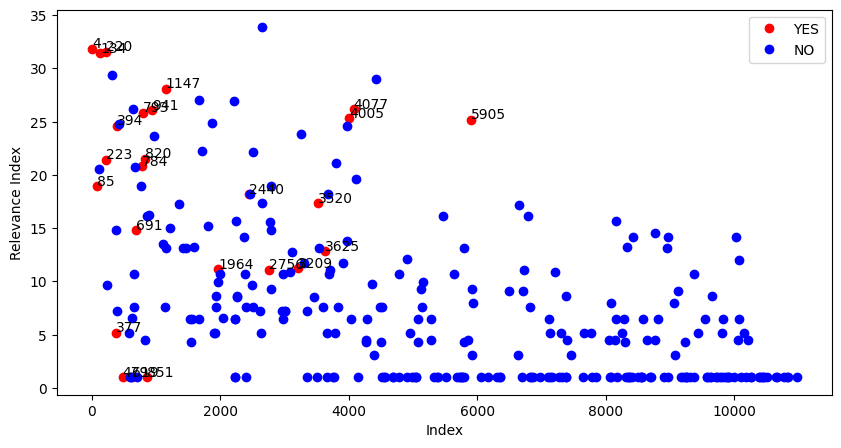

In [23]:
# plot the dot plot of the relevance_index of YESs and NOs of the test data set
plt.figure(figsize=(10, 5))
plt.plot(relvant_index, relevant_relevance_index_list, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_relevance_index_list, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Relevance Index")
plt.legend()

# add labels for the relevant index points
for i, index in enumerate(relvant_index):
    plt.text(index, relevant_relevance_index_list[i]+0.1, str(index), color='black', fontsize=10)

# # add labels for the relevant index points
# for i, index in enumerate(non_relevant_index):
#     plt.text(index, non_relevant_relevance_index_list[i], str(index), color='black', fontsize=10)

plt.show()

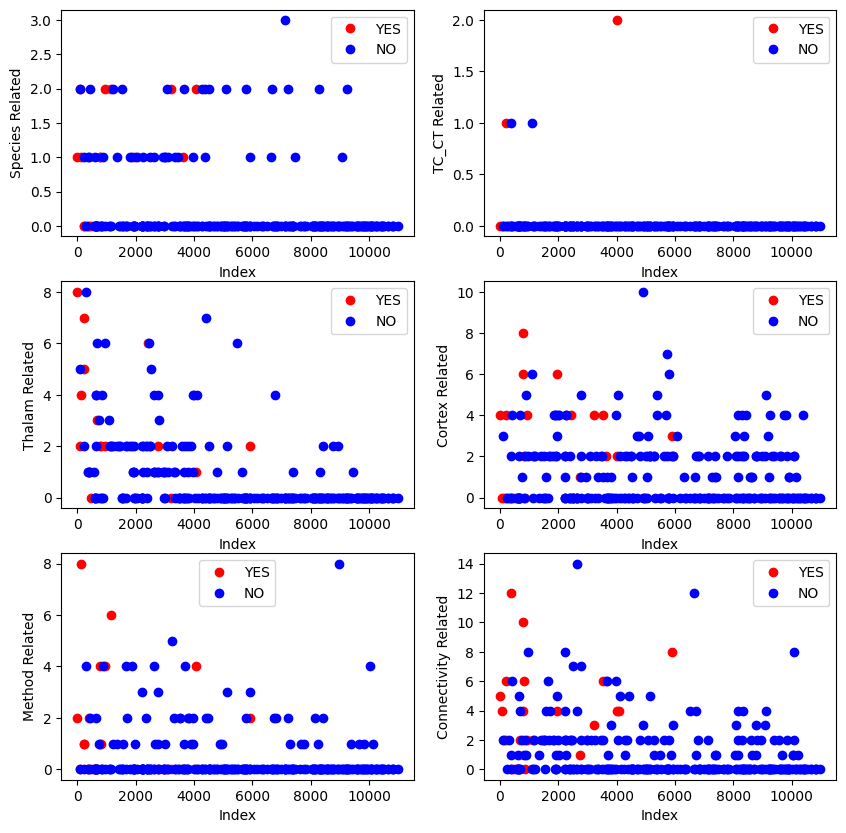

In [16]:
# plot the 6 dot plots of the species_related, tc_ct_related, thalam_related, cortex_related, method_related, connectivity_related of YESs and NOs of the test data set in 2 rows in the same figure
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(relvant_index, relevant_species, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_species, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Species Related")
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(relvant_index, relevant_tc_ct, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_tc_ct, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("TC_CT Related")
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(relvant_index, relevant_thalam, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_thalam, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Thalam Related")
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(relvant_index, relevant_cortex, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_cortex, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Cortex Related")
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(relvant_index, relevant_method, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_method, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Method Related")
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(relvant_index, relevant_connectivity, 'ro', label="YES")
plt.plot(non_relevant_index, non_relevant_connectivity, 'bo', label="NO")
plt.xlabel("Index")
plt.ylabel("Connectivity Related")
plt.legend()

plt.show()


In [18]:
def pick_values_uniformly(data, n):
    """Pick up `n` values uniformly from `data`."""
    if n <= 0:
        return []

    # Determine the range of the data
    min_val, max_val = min(data), max(data)

    threshold = (max_val - min_val) / n / 2

    # If n is 1, just return the midpoint
    if n == 1:
        return [(min_val + max_val) / 2]

    # Calculate the interval size
    interval = (max_val - min_val) / (n - 1)

    # Get the uniform values
    return [min_val + i * interval for i in range(n)], threshold

# data = [1, 3, 5, 2, 8, 10, 2]
n = 5
density_display_index, thres = pick_values_uniformly(relevant_relevance_index_list + non_relevant_relevance_index_list, n)
print(density_display_index)

[1.0, 9.213376488680064, 17.426752977360128, 25.640129466040193, 33.853505954720255]


Numer of relevant literature: 25
Number of not relevant literature: 267



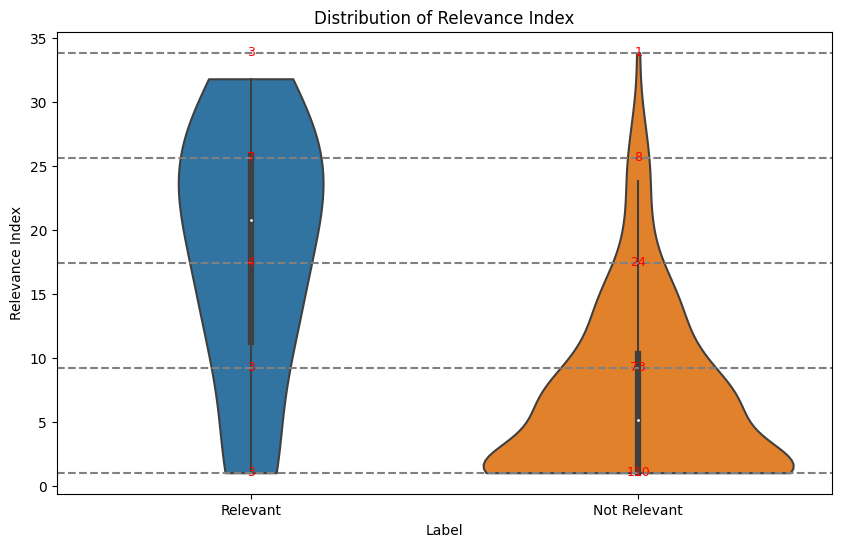

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Printing the length of lists
print("Numer of relevant literature:", len(relevant_relevance_index_list))
print("Number of not relevant literature:", len(non_relevant_relevance_index_list))
print()

# Create a DataFrame for plotting
df = pd.DataFrame({'Relevance Index': relevant_relevance_index_list + non_relevant_relevance_index_list, 
                   'Label': ['Relevant'] * len(relevant_relevance_index_list) + ['Not Relevant'] * len(non_relevant_relevance_index_list)})

# Draw the violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='Label', y='Relevance Index', data=df, bw='scott', cut=0)

relevance_indices = density_display_index  # Replace with your relevance indices

threshold = thres  # Adjust this based on your desired range around the relevance index

for index in relevance_indices:
    ax.axhline(index, color='gray', linestyle='--')
    
    for i, label in enumerate(df['Label'].unique()):
        # Filter data points close to the current relevance index
        close_points = df[(df['Label'] == label) & (np.abs(df['Relevance Index'] - index) < threshold)]
        density = len(close_points)
        
        ax.text(i, index + 0.1, str(density), ha='center', va='center', color='red', fontsize=9)  # adjust the vertical offset (0.1 here) as necessary

plt.title('Distribution of Relevance Index')
plt.show()

In [20]:
import scipy.stats as stats

# Check the equality of variances
var_relevant = np.var(relevant_relevance_index_list)
var_non_relevant = np.var(non_relevant_relevance_index_list)
print('Variance of relevant:', var_relevant)
print('Variance of non-relevant:', var_non_relevant)
print(var_relevant/var_non_relevant)
# statistic, p_value = stats.levene(relevant_relevance_index_list, non_relevant_relevance_index_list)

# # Print the results
# print('Levene test statistic:', statistic)
# print('p-value:', p_value)

Variance of relevant: 89.24912545176639
Variance of non-relevant: 46.04493234484723
1.9383050621802906


In [21]:
# Calculate the t-statistic and p-value
t_statistic, p_value = stats.ttest_ind(relevant_relevance_index_list, non_relevant_relevance_index_list)

# Print the results
print('t-statistic:', t_statistic)
print('p-value:', p_value)

t-statistic: 7.9003888497366255
p-value: 5.810436540886949e-14


<h3> Next step: manually read papers and find all actually related literature </h3>